In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# Initialize R^2 score dictionary
r2_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

mae_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

valid_target_properties = []

In [3]:
# target_property_list = ['voltage', 'energy', 'conductivity', 'columbic_efficiency']
target_property_list = ['voltage', 'energy', 'conductivity','columbic Efficiency']

In [2]:
path='/content/drive/MyDrive/2022_Battery_Data/'

In [3]:
text_data=pd.read_csv(f'{path}embeddings_matbert-base-cased_robo_75966 (1).csv')
text_data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [6]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

for target_property in target_property_list:
    print(f"STARTING PROPERTY {target_property.upper()}")
    try:
        df1 = pd.read_excel(f'{path}{target_property}.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, text_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        print(f"Starting model {name}")
        fold_r2_accuracies = []
        fold_mae_accuracies = []

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]


            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            fold_r2_accuracies.append(r2)

            mae = mean_absolute_error(y_test, y_pred)
            fold_mae_accuracies.append(mae)

            # print(f"Completed fold {fold} with MAE {mae}")

        mae_scores[name].append(np.average(fold_mae_accuracies))
        r2_scores[name].append(np.average(fold_r2_accuracies))

        print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")


STARTING PROPERTY VOLTAGE
Starting model Linear Regression
Finished property Linear Regression with average MAE 1.294127357334326
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 0.6997048372590949
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 0.6239643414787336
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 0.6660701176560511
Starting model Decision Tree Regressor
Finished property Decision Tree Regressor with average MAE 0.8521798329468415
STARTING PROPERTY ENERGY
Starting model Linear Regression
Finished property Linear Regression with average MAE 1057.294984421447
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 600.3988122195326
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 499.48571816403745
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 488.42242982650004
Sta

In [7]:
(mae_scores['Decision Tree Regressor'][-4:])

[np.float64(0.8521798329468415),
 np.float64(611.4974681788375),
 np.float64(8.157421507425987),
 np.float64(12.781916959047024)]

In [5]:
valid_target_properties=['Voltage','Energy','Conductivity','Columbic Efficiency']

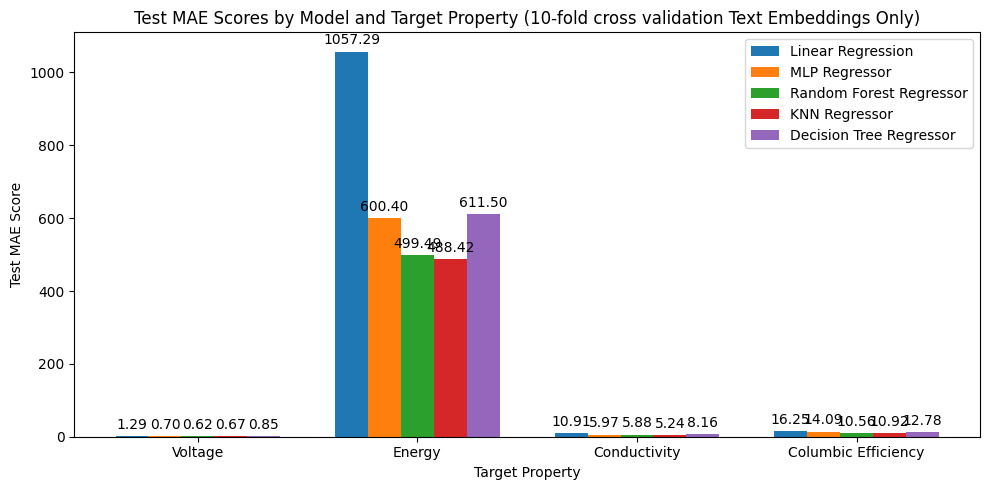

In [9]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores(scores)
    rects_visible = ax.bar(x + offset, visible, width, label=label, color=color)

    # Draw hatched rectangles for invalid scores at fixed height
    hatch_height = 0.05  # fixed height for placeholder
    for i, invalid in enumerate(is_invalid):
        if invalid:
            ax.bar(x[i] + offset, hatch_height, width,
                   fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"][-4:], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"][-4:], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"][-4:], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"][-4:], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"][-4:], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Test MAE Scores by Model and Target Property (10-fold cross validation Text Embeddings Only)')
ax.set_xticks(x)
ax.set_xticklabels([prop.title() for prop in target_property_list], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()

[0 1 2 3] -0.3 [np.float64(1.294127357334326)] 0.15 Linear Regression tab:blue
<BarContainer object of 1 artists>
[0 1 2 3] -0.15 [np.float64(0.6997048372590949)] 0.15 MLP Regressor tab:orange
<BarContainer object of 1 artists>
[0 1 2 3] 0 [np.float64(0.6239643414787336)] 0.15 Random Forest Regressor tab:green
<BarContainer object of 1 artists>
[0 1 2 3] 0.15 [np.float64(0.6660701176560511)] 0.15 KNN Regressor tab:red
<BarContainer object of 1 artists>
[0 1 2 3] 0.3 [np.float64(0.8521798329468415)] 0.15 Decision Tree Regressor tab:purple
<BarContainer object of 1 artists>


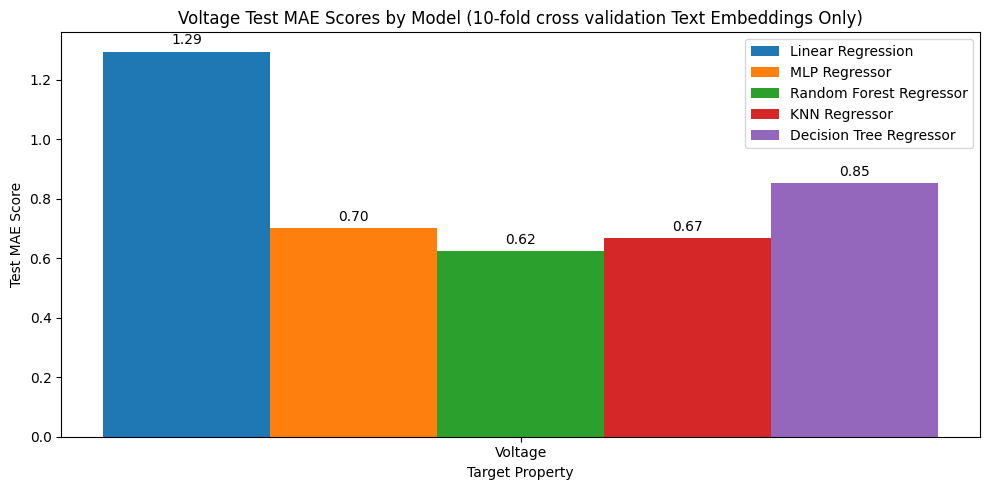

In [10]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores([scores[0]])
    rects_visible = ax.bar(x[0] + offset, visible, width, label=label, color=color)
    print(x, offset, visible, width, label, color)
    print(rects_visible)

    # Draw hatched rectangles for invalid scores at fixed height
    # hatch_height = 0.05  # fixed height for placeholder
    # for i, invalid in enumerate(is_invalid):
    #     if invalid:
    #         ax.bar(x[i] + offset, hatch_height, width,
    #                fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"][-4:], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"][-4:], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"][-4:], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"][-4:], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"][-4:], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Voltage Test MAE Scores by Model (10-fold cross validation Text Embeddings Only)')
ax.set_xticks([0])

ax.set_xticklabels(['Voltage'], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()

In [6]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

target_property = "voltage"
df1 = pd.read_excel(f'{path}{target_property}.xlsx')

avg_df = df1.groupby('jid')['Value'].mean().reset_index()
avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

merged_df = pd.merge(avg_df, text_data, left_on='jid', right_on='id')
merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()


# Extract features and target
X = merged_df.drop(columns=['Value', 'id', 'jid'])
X = X.select_dtypes(include=[np.number])  # only numeric features
y = merged_df['Value'].values


# Normalize features for MLP/KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Store valid target property for plotting
valid_target_properties.append(target_property)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['absolute_error']
}
# === RandomizedSearchCV to find best params ===
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)
search.fit(X, y)
best_params = search.best_params_
print("Best Parameters:", best_params)

# === Cross-validation using best model ===
best_model = RandomForestRegressor(**best_params, random_state=42)

fold_mae_accuracies = []
fold_r2_accuracies = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    fold_mae_accuracies.append(mae)
    fold_r2_accuracies.append(r2)




Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'absolute_error', 'bootstrap': False}


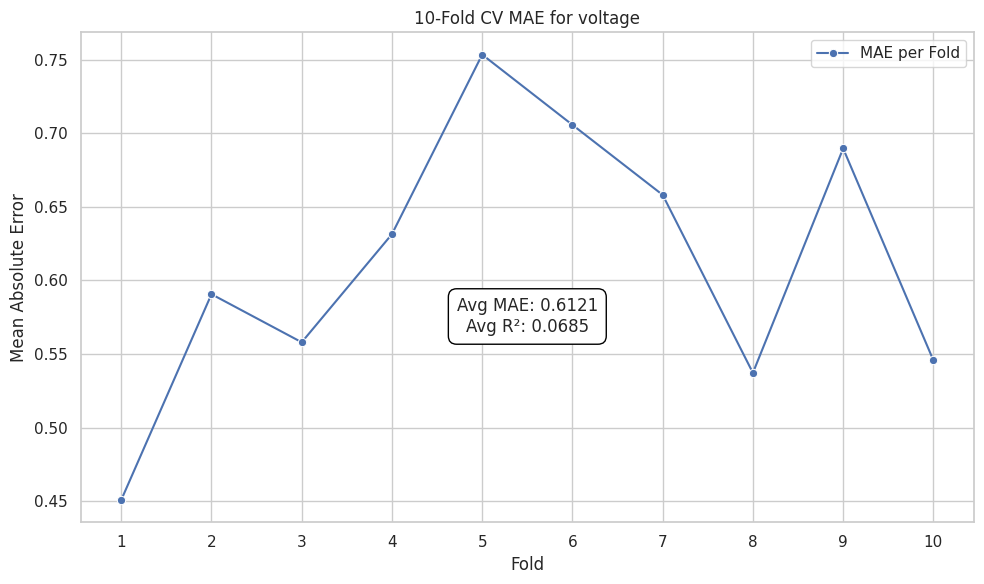

In [8]:
# === Plot MAE per fold ===
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=fold_mae_accuracies, marker='o', label='MAE per Fold')
plt.title(f"10-Fold CV MAE for {target_property}")
plt.xlabel("Fold")
plt.ylabel("Mean Absolute Error")
plt.xticks(range(1, 11))

# === Add result box without using patches ===
box_text = f"Avg MAE: {np.mean(fold_mae_accuracies):.4f}\nAvg R²: {np.mean(fold_r2_accuracies):.4f}"
xpos = 5.5
ypos = max(fold_mae_accuracies) * 0.75
plt.text(
    xpos, ypos, box_text,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
    ha='center'
)

plt.legend()
plt.tight_layout()
plt.show()

In [9]:
best_params

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 10,
 'criterion': 'absolute_error',
 'bootstrap': False}

In [10]:
fold_mae_accuracies

[0.45086168929105436,
 0.5906437054391802,
 0.5579812475554421,
 0.6314245760125713,
 0.7533797831796258,
 0.7056487290735083,
 0.6580791750632882,
 0.5372012142261023,
 0.6896251409493476,
 0.5457051759203556]

In [11]:
from sklearn.model_selection import cross_val_score
results = search.cv_results_
results_df = pd.DataFrame(results, columns=['params', 'mean_test_score'])

# Convert to positive MAE
results_df.rename(columns={'mean_test_score': 'mean_score'}, inplace=True)
results_df['mean_score'] = -results_df['mean_score']  # Convert from negative MAE to actual MAE

# Flatten the params dictionary for visualization
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

In [12]:
results_df

,mean_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,bootstrap
0,0.635674,200,5,1,sqrt,30.0,absolute_error,True
1,0.620066,200,5,4,sqrt,30.0,absolute_error,False
2,0.630634,500,2,2,None,20.0,absolute_error,True
3,0.616913,500,2,4,log2,30.0,absolute_error,True
4,0.614926,200,10,4,log2,10.0,absolute_error,False
5,0.843871,200,5,2,None,50.0,absolute_error,False
6,0.620362,100,2,2,log2,20.0,absolute_error,True
7,0.629323,500,2,1,log2,20.0,absolute_error,False
8,0.628885,200,5,4,None,30.0,absolute_error,True
9,0.629855,500,2,1,sqrt,20.0,absolute_error,False


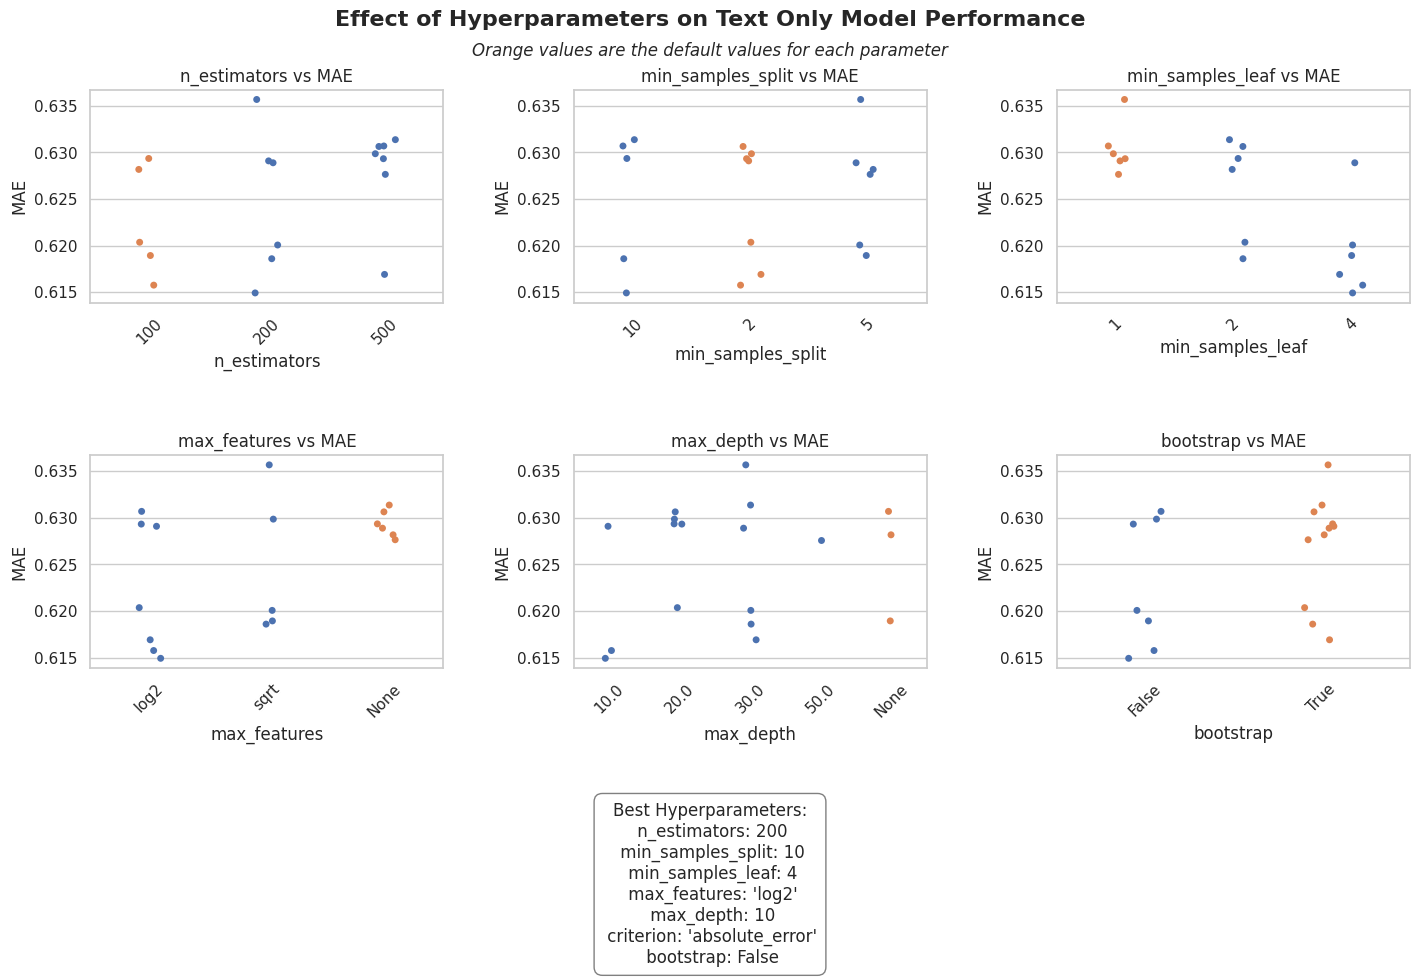

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the default features
default_model = RandomForestRegressor()
defaults = default_model.get_params()
defaults['max_features'] = 'None'

# Filter out outliers with high MAEs for clear visualization
filtered_df = results_df[results_df['mean_score'] <= 0.75].copy()

# Drop only the score column; include all params
param_columns = [col for col in results_df.columns if col != "mean_score" and col != "criterion"]

# Convert all param columns to string for consistent plotting
plot_df = filtered_df.copy()
for col in param_columns:
    plot_df[col] = plot_df[col].astype(str).replace("nan", "None")

# Set up subplot grid
n_cols = 3
n_rows = (len(param_columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot each parameter vs. mean_score
for i, param in enumerate(param_columns):

    default_value = str(defaults[param])
    plot_df['is_default'] = plot_df[param] == default_value

    ordering = sorted(plot_df[param].unique(), key=lambda x: (x == "nan" or x == "None", x)) # put the nan values at the end
    sns.stripplot(data=plot_df, x=param, y='mean_score', ax=axes[i], order=ordering, jitter=True, hue='is_default', legend=False)
    axes[i].set_title(f"{param} vs MAE")
    # axes[i].set_xlabel(param)
    axes[i].set_ylabel("MAE")
    axes[i].tick_params(axis='x', rotation=45)

fig.suptitle("Effect of Hyperparameters on Text Only Model Performance", fontsize=16, fontweight='bold')
fig.text(0.5, 0.94, "Orange values are the default values for each parameter", ha='center', va='top', fontsize=12, style='italic')
# Format best_params nicely as a string
best_params_str = "\n".join(
    f" {k}: {repr(v)}" for k, v in search.best_params_.items()
)

# Add a textbox at the bottom center
fig.text(
    0.5, -0.01, f"Best Hyperparameters:\n{best_params_str}",
    ha='center', va='top', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray")
)
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.88)
plt.show()

In [32]:
best_params['n_estimators']

200

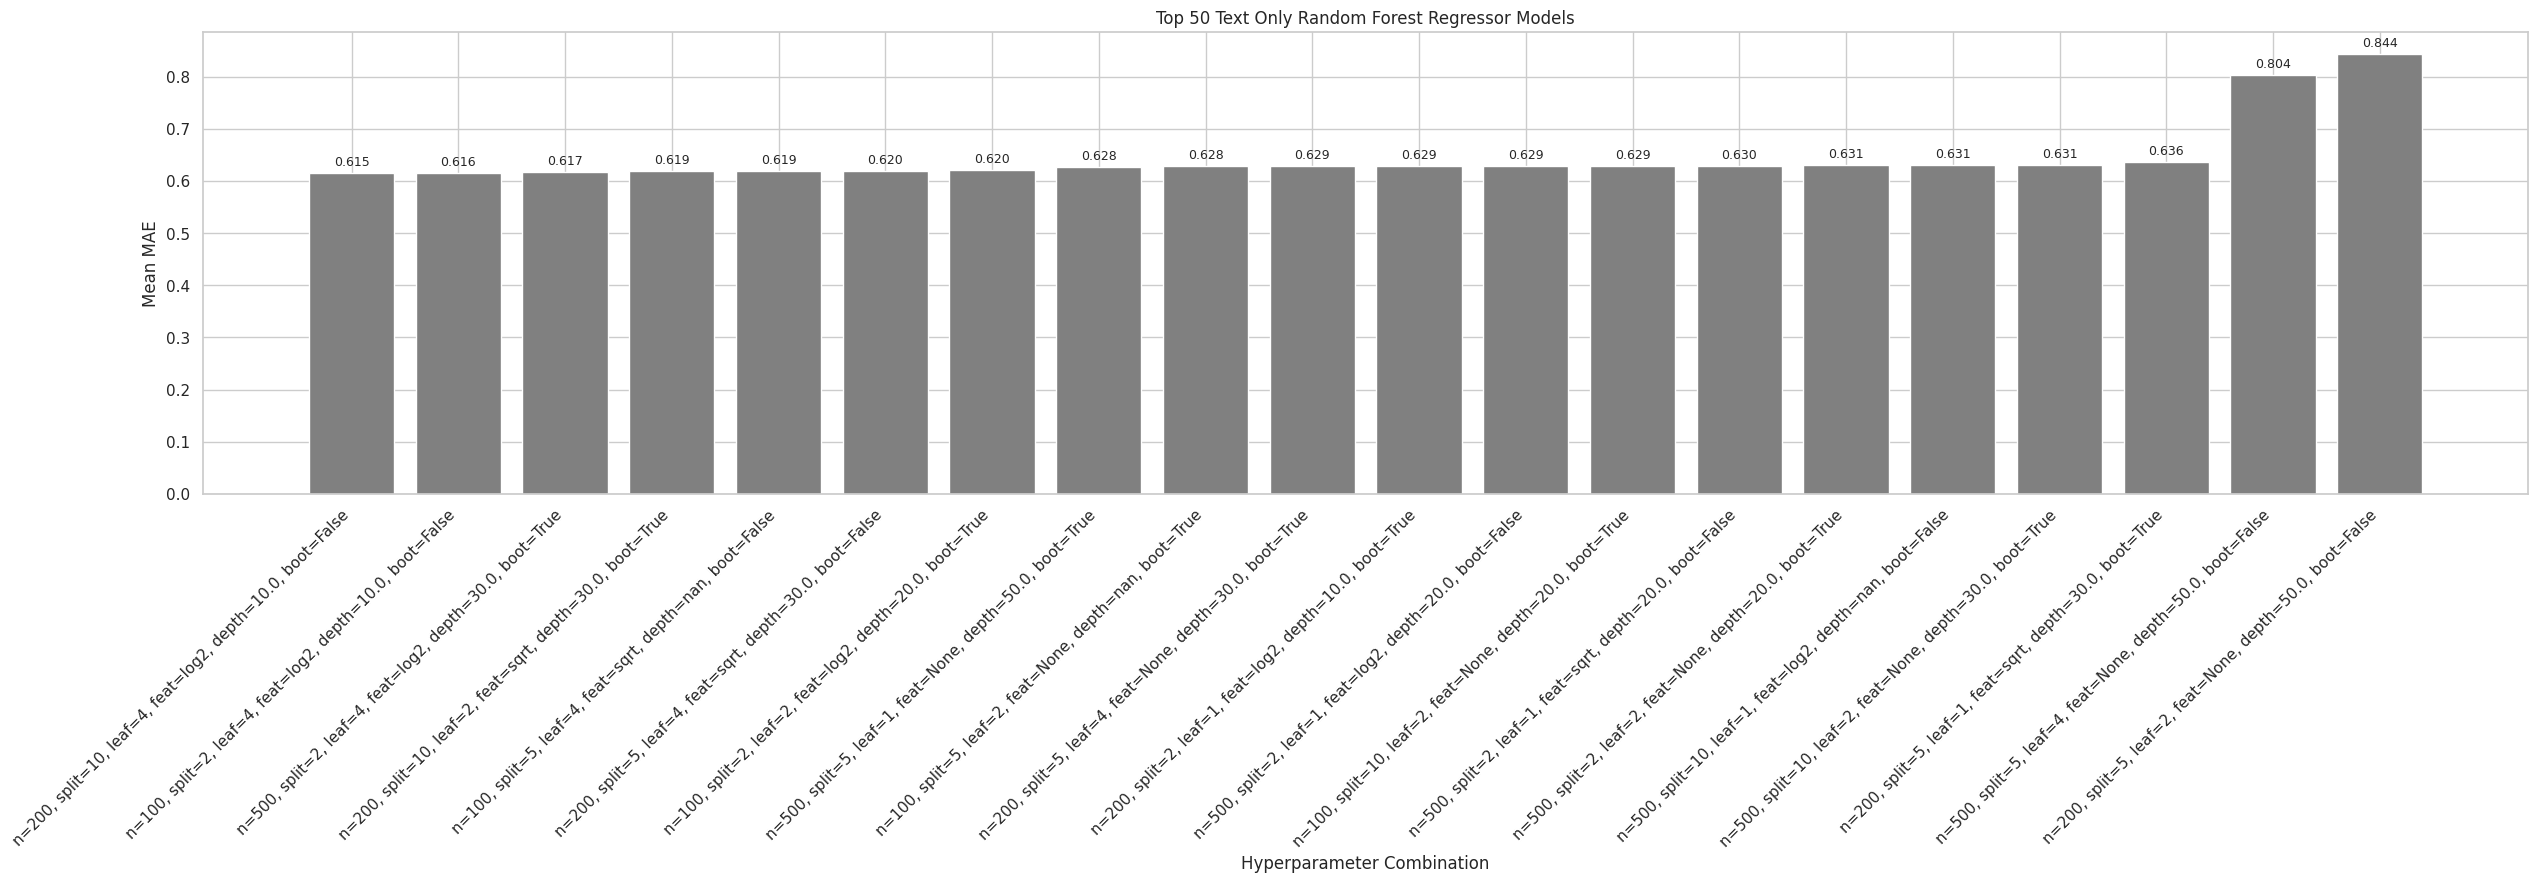

In [16]:
import matplotlib.pyplot as plt



# Sort and select top N models
top_n = 50
plot_df = results_df.sort_values("mean_score").head(top_n).copy()

# Create readable labels
plot_df["params_str"] = plot_df.apply(
    lambda row: f"n={row.n_estimators}, split={row.min_samples_split}, leaf={row.min_samples_leaf}, feat={row.max_features}, depth={row.max_depth}, boot={row.bootstrap}",
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(30, 6))
bars = ax.bar(plot_df["params_str"], plot_df["mean_score"], color="gray")

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(plot_df["mean_score"]),
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Labels and layout
ax.set_ylabel("Mean MAE")
ax.set_xlabel("Hyperparameter Combination")
ax.set_title(f"Top {top_n} Text Only Random Forest Regressor Models")
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()